## Value at Risk (VaR)

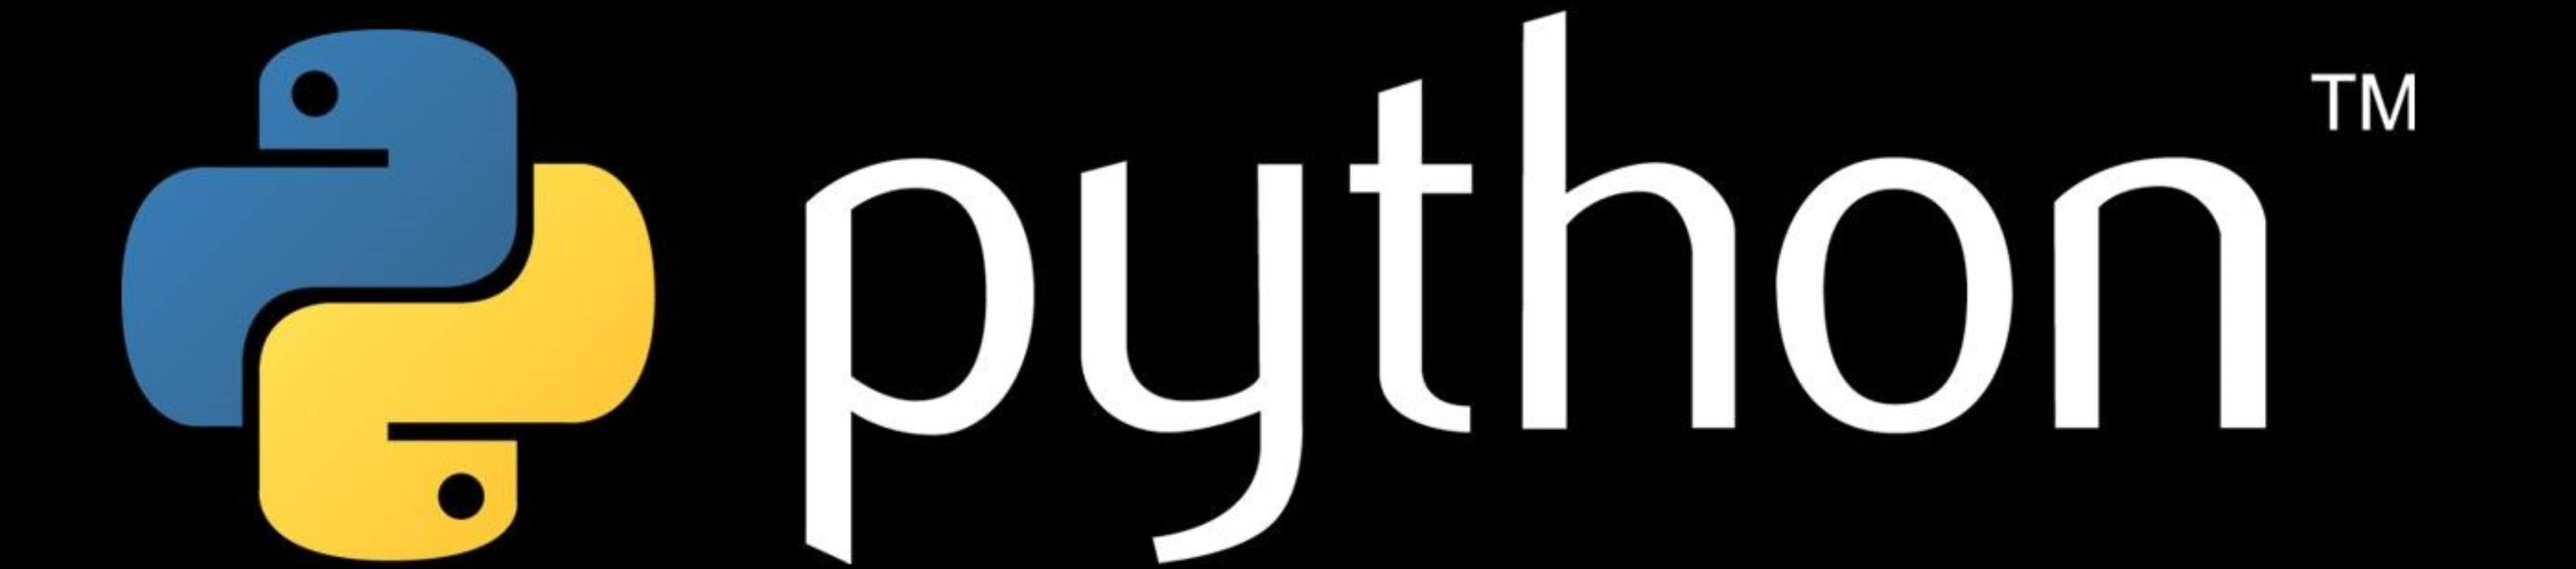

#### Hemant Thapa

#### 1. Import Libraries 

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import norm

#### 2. List of Indices for Value at Risk (VaR)

In [2]:
tickers = ['^GSPC', 'SPY', '^FTSE', '^FTMC']

In [3]:
df_adj_close = pd.DataFrame()
for i in tickers:
    df = yf.download(i, period='10Y')
    df_adj_close[i] = df['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
df_adj_close.dropna(inplace=True)

In [5]:
df_adj_close.isnull().sum()

^GSPC    0
SPY      0
^FTSE    0
^FTMC    0
dtype: int64

In [6]:
df_adj_close[:5]

,^GSPC,SPY,^FTSE,^FTMC
Date,,,,
2014-02-18,1840.760010,153.770828,6796.399902,16342.099609
2014-02-19,1828.750000,152.752640,6796.700195,16347.299805
2014-02-20,1839.780029,153.654037,6813.000000,16368.799805
2014-02-21,1836.250000,153.478683,6838.100098,16460.900391
2014-02-24,1847.609985,154.330017,6865.899902,16539.300781


#### 3. Log Return 


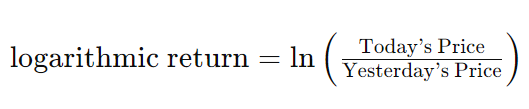

In [7]:
log_returns = np.log(df_adj_close / df_adj_close.shift(1))
log_returns = log_returns.dropna()

In [8]:
log_returns.shape

(2470, 4)

In [9]:
log_returns.isnull().sum()

^GSPC    0
SPY      0
^FTSE    0
^FTMC    0
dtype: int64

#### 4. Calculating Portfolio Value 

In [10]:
# value of portfolio 
portfolio_value = 100000

In [11]:
weights = np.array([1/len(tickers)] * len(tickers))
weights

array([0.25, 0.25, 0.25, 0.25])

In [12]:
historical_returns = (log_returns * weights).sum(axis=1)
historical_returns[:5]

Date
2014-02-19   -0.003207
2014-02-20    0.003902
2014-02-21    0.001556
2014-02-24    0.005127
2014-02-25   -0.001896
dtype: float64

In [13]:
historical_returns.shape

(2470,)

In [14]:
# total number of days
days = 5
historical_x_day_returns = historical_returns.rolling(window=days).sum()

In [15]:
cov_matrix = log_returns.cov() * 252
portfolio_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)

In [16]:
confidence_levels = [0.90, 0.95, 0.99]
VaRs = []
for cl in confidence_levels:
    VaR = portfolio_value * (norm.ppf(1 - cl) * portfolio_std_dev * np.sqrt(days / 252) - historical_returns.mean() * days)
    VaRs.append(VaR)

In [17]:
print("Confidence Level - Value at Risk")
for cl, VaR in zip(confidence_levels, VaRs):
    print(f"{cl*100}% Confidence: £{VaR:,.2f}")

Confidence Level - Value at Risk
90.0% Confidence: £-2,787.92
95.0% Confidence: £-3,542.90
99.0% Confidence: £-4,959.13


In [18]:
# returns to dollar values for the histogram
historical_x_day_returns_pounds = historical_x_day_returns * portfolio_value
historical_x_day_returns_pounds.dropna(inplace=True)

In [19]:
historical_x_day_returns_pounds[:5]

Date
2014-02-25    548.182014
2014-02-26    670.778026
2014-02-27    653.374962
2014-02-28    933.422667
2014-03-03   -846.054025
dtype: float64

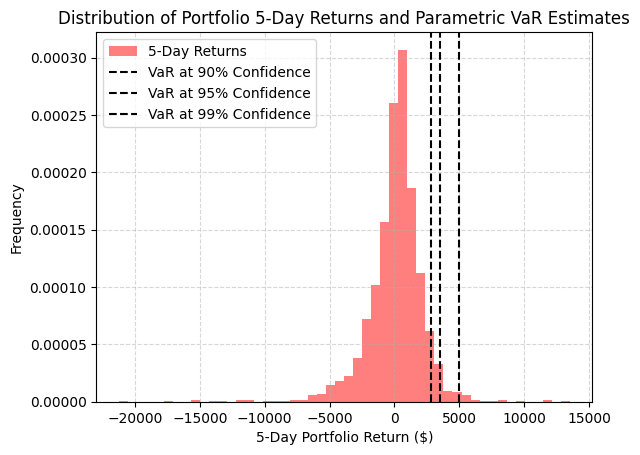

In [24]:
plt.hist(historical_x_day_returns_pounds, bins=50, density=True, alpha=0.5, label=f'{days}-Day Returns', color='red')
for cl, VaR in zip(confidence_levels, VaRs):
    plt.axvline(x=-VaR, linestyle='--', color='black', label='VaR at {}% Confidence'.format(int(cl * 100)))
plt.xlabel(f'{days}-Day Portfolio Return ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimates')
plt.grid(True, ls='--', alpha=0.5)
plt.legend()
plt.show()